In [1]:
import findspark
findspark.init()

import sys
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings

from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.ml.evaluation import RegressionEvaluator


#from pyspark.ml.recommendation import ALS, ALSModel
#from pyspark.mllib.recommendation import MatrixFactorizationModel
from pyspark.sql import Row, SQLContext,SparkSession
import os
os.environ['HADOOP_USER_NAME'] = "hadoop"

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Creamos el spark SparkContext
sc = SparkContext(appName="MLIB-RL")
sc.setLogLevel("WARN")
sqlcontext = SQLContext(sc)

22/07/19 21:24:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/07/19 21:24:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/07/19 21:24:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
# definimos la variable spark, en la que creamos una Sesión
spark = SparkSession \
        .builder \
        .appName("MLIB-RL") \
        .getOrCreate()

In [5]:
spark

## Carga de datos

Se realiza la carga de datos de la data de un día anterior a los datos

In [12]:
df = spark.read.option("delimiter", "|").csv(path="/opt/smart-parking/comments_limpio.csv", header=True)

In [15]:
df = df[["author_id", "fecha"]]

In [16]:
df.show()

+---------+----------+
|author_id|     fecha|
+---------+----------+
|   700035|2019-01-01|
|   418510|2016-01-01|
|   187737|2014-10-01|
|   195477|2014-08-01|
|   103944|2013-08-01|
|   107607|2010-02-01|
|   768457|2019-02-01|
|   636671|2018-01-01|
|    10247|2017-03-01|
|    14229|2016-12-01|
|    45840|2016-12-01|
|   271886|2016-09-01|
|     5433|2016-01-01|
|   512021|2015-10-01|
|    10247|2015-07-01|
|   136814|2014-07-01|
|   144420|2013-11-01|
|   560116|2013-04-01|
|   106308|2013-04-01|
|   108996|2011-10-01|
+---------+----------+
only showing top 20 rows



In [9]:
df_parking = spark.read.parquet("hdfs://hadoop-namenode:9000/data/Parkings/TresCrucesShopping/year=2022/month=7/")

In [10]:
#df_parkin_joined = df_parking.union(df_parking2).union(df_parking3)
df_parkin_joined = df_parking

In [11]:
df_parking_cleaned = df_parkin_joined \
                        .withColumn("year", year(col("device_timestamp"))) \
                        .withColumn("month", month(col("device_timestamp"))) \
                        .withColumn("day", dayofmonth(col("device_timestamp"))) 
                        #.drop("device_slots", "parking_address", "parking_description", "parking_weather_status_detailed", "parking_uuid", "parking_holiday_description", "level_name", "area_occupation", "device_timestamp")

In [9]:
df_parking_cleaned_2 = df_parking \
                        .drop("device_slots", "parking_address", "parking_description", "parking_weather_status_detailed", "parking_uuid", "parking_holiday_description", "level_name", "area_occupation", "device_timestamp")

In [12]:
df_parking_cleaned = df_parking_cleaned \
    .withColumn("parking_temperature", col("parking_temperature").cast("double"))\
    .withColumn("parking_humidity", col("parking_humidity").cast("double"))
            

In [11]:
df_parking_cleaned_without_duplicated = df_parking_cleaned.dropDuplicates()

In [13]:
df_parkin_joined.coalesce(1).write.format("parquet").mode("overwrite").save("hdfs://hadoop-namenode:9000/machineLearning/Parkings/TresCrucesShopping/dataset_julio.parquet/")

22/07/19 08:25:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [12]:
df_parking_cleaned_without_duplicated.write.format("parquet").mode("overwrite").save("hdfs://hadoop-namenode:9000/machineLearning/Parkings/TresCrucesShopping/dataset_without_duplicated.parquet")

22/07/18 23:18:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Ingeniería de atributos

In [13]:
df_parking_machine_learning = spark.read.parquet("hdfs://hadoop-namenode:9000/machineLearning/Parkings/TresCrucesShopping/dataset_without_duplicated.parquet/")

In [14]:
df_parkin_joined.printSchema()

root
 |-- parking_name: string (nullable = true)
 |-- parking_id: string (nullable = true)
 |-- parking_address: string (nullable = true)
 |-- parking_description: string (nullable = true)
 |-- device_timestamp: timestamp (nullable = true)
 |-- device_id: string (nullable = true)
 |-- parking_latitude: double (nullable = true)
 |-- parking_longitude: double (nullable = true)
 |-- parking_temperature: string (nullable = true)
 |-- parking_humidity: string (nullable = true)
 |-- parking_uuid: string (nullable = true)
 |-- level_id: integer (nullable = true)
 |-- area_id: integer (nullable = true)
 |-- area_name: string (nullable = true)
 |-- area_total_spots: integer (nullable = true)
 |-- device_slots: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- parking_weather_status: string (nullable = true)
 |-- parking_weather_status_detailed: string (nullable = true)
 |-- parking_wind_speed: double (nullable = true)
 |-- parking_holiday_status: boolean (nullable = 

In [14]:
dfp = df_parking_machine_learning.toPandas() #Creamos este dataframe para mejor visualización de datos

In [15]:
dfp.head(10) 

,parking_name,parking_id,device_id,parking_latitude,parking_longitude,parking_temperature,parking_humidity,level_id,area_id,area_name,...,minutes,area_occupied_spots,area_occupation_percentage,area_available_spots,slot_id,slot_state,day,hour,year,month
0,TresCrucesShopping,1,9AA1AD57EC8B8856,-34.894308,-56.166438,9.73,66.0,2,1,A,...,29,4,40,6,6,True,15,9,2022,7
1,TresCrucesShopping,1,51FE29B1E7DACCB6,-34.894308,-56.166438,9.73,66.0,2,3,C,...,29,8,80,2,4,False,15,9,2022,7
2,TresCrucesShopping,1,CE6EFF5988ECBF74,-34.894308,-56.166438,9.73,66.0,3,1,A,...,30,6,60,4,5,True,15,9,2022,7
3,TresCrucesShopping,1,4DE1C372D9293D6F,-34.894308,-56.166438,9.73,66.0,1,3,C,...,30,6,60,4,7,False,15,9,2022,7
4,TresCrucesShopping,1,DD5F6C5BDA3D7A95,-34.894308,-56.166438,9.84,100.0,1,2,B,...,44,4,40,6,1,False,12,16,2022,7
5,TresCrucesShopping,1,CE6EFF5988ECBF74,-34.894308,-56.166438,9.84,100.0,3,1,A,...,44,4,40,6,6,True,12,16,2022,7
6,TresCrucesShopping,1,51FE29B1E7DACCB6,-34.894308,-56.166438,9.84,100.0,2,3,C,...,45,4,40,6,2,False,12,16,2022,7
7,TresCrucesShopping,1,4DE1C372D9293D6F,-34.894308,-56.166438,9.84,100.0,1,3,C,...,47,6,60,4,1,True,12,16,2022,7
8,TresCrucesShopping,1,DD5F6C5BDA3D7A95,-34.894308,-56.166438,9.84,100.0,1,2,B,...,49,4,40,6,6,True,12,16,2022,7
9,TresCrucesShopping,1,51FE29B1E7DACCB6,-34.894308,-56.166438,9.84,100.0,2,3,C,...,49,3,30,7,7,False,12,16,2022,7


In [16]:
dfp.describe() #vemos la descripción estadística de los datos numéricos

,parking_latitude,parking_longitude,parking_temperature,parking_humidity,level_id,area_id,area_total_spots,parking_wind_speed,minutes,area_occupied_spots,area_occupation_percentage,area_available_spots,slot_id,day,hour,year,month
count,1.303272e+06,1.303272e+06,1.303272e+06,1.303272e+06,1.303272e+06,1.303272e+06,1303272.0,1.303272e+06,1.303272e+06,1.303272e+06,1.303272e+06,1.303272e+06,1.303272e+06,1.303272e+06,1.303272e+06,1303272.0,1303272.0
mean,-3.489431e+01,-5.616644e+01,9.861153e+00,8.817044e+01,1.888238e+00,2.111501e+00,10.0,3.114869e+00,2.936732e+01,4.946464e+00,4.946464e+01,5.053536e+00,5.499998e+00,9.753502e+00,1.470442e+01,2022.0,7.0
std,1.421086e-14,2.131629e-14,4.396811e-01,1.646142e+01,7.371358e-01,9.937786e-01,0.0,7.675835e-01,1.736817e+01,1.614499e+00,1.614499e+01,1.614499e+00,2.872292e+00,5.130665e+00,4.058676e+00,0.0,0.0
min,-3.489431e+01,-5.616644e+01,9.010000e+00,4.900000e+01,1.000000e+00,1.000000e+00,10.0,2.060000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00,2022.0,7.0
25%,-3.489431e+01,-5.616644e+01,9.730000e+00,6.600000e+01,1.000000e+00,1.000000e+00,10.0,2.570000e+00,1.400000e+01,4.000000e+00,4.000000e+01,4.000000e+00,3.000000e+00,5.000000e+00,1.100000e+01,2022.0,7.0
50%,-3.489431e+01,-5.616644e+01,9.840000e+00,1.000000e+02,2.000000e+00,2.000000e+00,10.0,2.570000e+00,2.900000e+01,5.000000e+00,5.000000e+01,5.000000e+00,6.000000e+00,9.000000e+00,1.500000e+01,2022.0,7.0
75%,-3.489431e+01,-5.616644e+01,9.840000e+00,1.000000e+02,2.000000e+00,3.000000e+00,10.0,4.120000e+00,4.400000e+01,6.000000e+00,6.000000e+01,6.000000e+00,8.000000e+00,1.500000e+01,1.800000e+01,2022.0,7.0
max,-3.489431e+01,-5.616644e+01,1.377000e+01,1.000000e+02,3.000000e+00,4.000000e+00,10.0,5.140000e+00,5.900000e+01,1.000000e+01,1.000000e+02,1.000000e+01,1.000000e+01,1.800000e+01,2.200000e+01,2022.0,7.0


<AxesSubplot:>

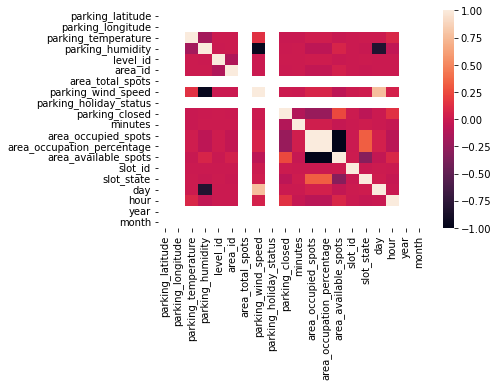

In [17]:
#hacemos un mapa de calor para ver las correlaciones entre los atributos que tenemos
corr = dfp.corr() 
sns.heatmap(corr, 
      xticklabels=corr.columns.values, 
      yticklabels=corr.columns.values) 

In [18]:
dfp2 = dfp.drop(["parking_latitude", "parking_longitude", "area_total_spots", ], axis=1)

<AxesSubplot:>

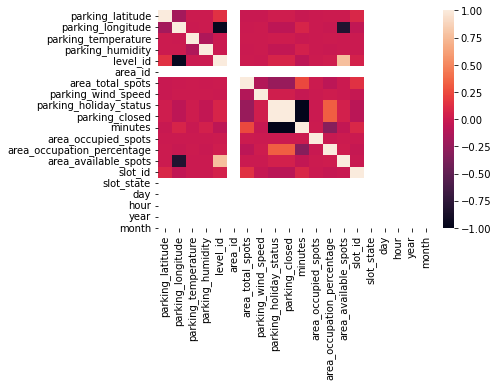

In [19]:
#hacemos un mapa de calor para ver las correlaciones entre los atributos que tenemos
corr2 = dfp2.corr() 
sns.heatmap(corr2, 
      xticklabels=corr.columns.values, 
      yticklabels=corr.columns.values) 

Vemos que los atributos tienen "poca" correlación, por lo que al momento los dejamos todos. 

In [ ]:
#Otra forma de ver la correlación, no solo con colores sino con los valores de cada correlación.

cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

corr2.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

Esta forma de ver la correlación es un poco más clara y podemos ver los valores, pero se mantiene la conclusión anterior.

# Preparation of Linear Regression

In [20]:
from pyspark.ml.feature import VectorAssembler

In [21]:
vectorAssembler = VectorAssembler(inputCols = ["level_id", "area_id", "parking_wind_speed", "parking_holiday_status",
                                               "parking_temperature", "parking_humidity", "parking_closed","minutes",
                                               "area_occupied_spots", "area_available_spots", "slot_id", "slot_state",
                                               "hour", "year", "month", "day"],outputCol = 'features')

In [22]:
va_df_parking = vectorAssembler.transform(df_parking_machine_learning)


In [23]:
va_df_parking = va_df_parking.select(['features', 'area_occupation_percentage'])
va_df_parking.show(3)

+--------------------+--------------------------+
|            features|area_occupation_percentage|
+--------------------+--------------------------+
|[2.0,1.0,4.12,0.0...|                        40|
|[2.0,3.0,4.12,0.0...|                        80|
|[3.0,1.0,4.12,0.0...|                        60|
+--------------------+--------------------------+
only showing top 3 rows



# Modelo RL con MLlib

In [24]:
splits = va_df_parking.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [25]:
from pyspark.ml.regression import LinearRegression


In [26]:
lr = LinearRegression(featuresCol = 'features', labelCol='area_occupation_percentage', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

22/07/18 23:34:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/07/18 23:34:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.916575002675703,-4.916575002679065,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 49.990852734020805


In [27]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.269495
r2: 0.999722


In [28]:
train_df.describe().show()

+-------+--------------------------+
|summary|area_occupation_percentage|
+-------+--------------------------+
|  count|                    912240|
|   mean|        49.451767078838905|
| stddev|        16.151912683698786|
|    min|                         0|
|    max|                       100|
+-------+--------------------------+



In [29]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","area_occupation_percentage","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="area_occupation_percentage",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+--------------------------+--------------------+
|        prediction|area_occupation_percentage|            features|
+------------------+--------------------------+--------------------+
|49.990852734003994|                        50|[1.0,1.0,2.06,0.0...|
| 40.15770272864923|                        40|[1.0,1.0,2.06,0.0...|
|49.990852734003994|                        50|[1.0,1.0,2.06,0.0...|
| 40.15770272864923|                        40|[1.0,1.0,2.06,0.0...|
| 40.15770272864923|                        40|[1.0,1.0,2.06,0.0...|
+------------------+--------------------------+--------------------+
only showing top 5 rows



R Squared (R2) on test data = 0.999722


In [ ]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

In [ ]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","area_occupation_percentage","features").show()

# Decision Tree

In [118]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'area_occupation_percentage')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="area_occupation_percentage", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0


In [119]:
dt_model.featureImportances

SparseVector(17, {7: 0.0016, 9: 0.1554, 10: 0.843})

## Modelo ALS

Construimos las recomendaciones usando el modelo ALS (Alternating Least Squares) en data de train.
Los parametros del modelo son los siguientes:

- maxIter: cantidad de iteraciones, el valor predeterminado es 10 pero luego de pruebas, nos quedamos con 8.
- regParam: especifica el parámetro de regularización (por defecto es 1, pero optamos por 0.05).

Luego se definen las columnas del dataset con las que va a trabajar el modelo:
- ColdStartStrategy= drop nos aseguramos de eliminar las filas con valores vacíos y por lo tanto no tener métricas con valores NAN.
El modelo puede trabajar con implicit o explicit preference, por defecto es implicit= False. En nuestro caso, trabajaremos con lo que viene predeterminado porque lo que indica las preferencias en nuestro dataset es un rating, o sea que sabemos explícitamente qué tanto le gustó una pelicula a un usuario. 

In [33]:
#separamos los datos en train y test
(train, test) = df_cleaned.randomSplit([0.8, 0.2]) 

In [34]:
#Definimos los parametros con los que vamos a entrenar el modelo y lo entrenamos
als = ALS(maxIter=8, regParam=0.05, userCol="User_ID", itemCol="Movie_ID", ratingCol="Rating",
          coldStartStrategy="drop")
model = als.fit(train)

In [37]:
model.save("/home/jovyan/model/")

In [ ]:
! ls /home/jovyan/model

In [ ]:
! ls /home/jovyan/model/itemFactors

In [ ]:
spark.read.parquet('/home/jovyan/model/itemFactors').show(10,False,True)

In [ ]:
! cat /home/jovyan/model/metadata/part-00000

In [ ]:
! ls /home/jovyan/model/userFactors

In [ ]:
spark.read.parquet('/home/jovyan/model/userFactors').show(10,False,True)

## Evaluación del modelo

Utilizamos RMSE, que calcula el promedio de los errores al cuadraro entre los valores predichos del conjunto de entrenamiento con los valores del conjunto de validación. Cuanto menor es el error, mejor es la capacidad de pronóstico del modelo según el criterio del RMSE.

Con un RMSE de 0.86, consideramos que obtenemos buenos resultados porque como el rating va del 1 al 5, el error que en promedio podremos cometer es de 17%. Es decir, dado un rating estimado, en promedio nos estaremos desviando un 17%, lo cual es un buen resultado.

In [44]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8615964679702744


In [45]:
predictions.show(10,False,True) #mostramos algunas predicciones luego de aplicar el algoritmo

-RECORD 0-----------------------------------------
 User_ID       | 2383                             
 Movie_ID      | 148                              
 Rating        | 2                                
 timestamp     | 974417654                        
 Sexo          | F                                
 Ocupacion     | 14                               
 Edad          | 25                               
 Codigo_postal | 95125                            
 Genero        | Drama                            
 Titulo        | Awfully Big Adventure, An (1995) 
 prediction    | 2.255461                         
-RECORD 1-----------------------------------------
 User_ID       | 3539                             
 Movie_ID      | 148                              
 Rating        | 3                                
 timestamp     | 966932408                        
 Sexo          | F                                
 Ocupacion     | 4                                
 Edad          | 25            

In [46]:
#Vemos la primera película recomendada para cada usuario
userRecs = model.recommendForAllUsers(1)

In [47]:
#Acá vemos que el resultado que obtenemos tiene dos columnas, una con el User_ID y la otra con una tupla que incluye el 
#Movie_ID y el rating estimado
userRecs.show()

+-------+-------------------+
|User_ID|    recommendations|
+-------+-------------------+
|   1580|   [[557, 4.94973]]|
|   4900|  [[572, 6.751706]]|
|   5300| [[557, 5.7473125]]|
|    471| [[3951, 5.294216]]|
|   1591|  [[572, 6.194825]]|
|   4101| [[2964, 6.058449]]|
|   1342| [[572, 4.8523083]]|
|   2122| [[572, 5.4402065]]|
|   2142| [[572, 5.2857795]]|
|    463|[[2309, 4.8618903]]|
|    833|[[2964, 6.4485483]]|
|   5803|[[1574, 6.3360844]]|
|   3794|[[2309, 5.0118876]]|
|   1645| [[2964, 6.847805]]|
|   3175|[[2192, 6.4620423]]|
|   4935|  [[682, 5.959664]]|
|    496|[[2562, 5.9101458]]|
|   2366| [[572, 4.9769077]]|
|   2866|[[1743, 5.0615377]]|
|   5156|  [[572, 6.002281]]|
+-------+-------------------+
only showing top 20 rows



In [49]:
users = df_ratings.select(als.getUserCol()).distinct().limit(3)

In [50]:
users

DataFrame[User_ID: string]

In [51]:
users.show()

+-------+
|User_ID|
+-------+
|    296|
|    467|
|    675|
+-------+

